In [1]:
import matplotlib.pyplot as plt
import sys
import math

sys.path.append('../../')
# from column import Column

from porousmedialab.column import Column

import numpy as np

%matplotlib inline
# %matplotlib notebook

from thawmeasurements import  Vh2, Vh3, C2h, C3h, C3D33, C2D33, C3D21, C2D21, C3D9, C2D9, Tm_nz, C1h_nz, F3Tm, F3T_frz, T3Tm, T2T_thw, F2Tm, F2T_frz, T1T_thw, T2Tm, F1T_frz, T1Tm, C1h, T1C1h, F1C1h, T2C1h, F2C1h, T3C1h, F3C1h, C1D9, T1C1D9, T2C1D9, T3C1D9, C1D21, T1C1D21, F1C1D21, T2C1D21, F2C1D21, T3C1D21, F3C1D21, C1D33, T1C1D33, F1C1D33, T2C1D33, F2C1D33, T3C1D33, F3C1D33, Tm, T1Tm, F1Tm, T2Tm, F2Tm, T3Tm, F3Tm, zm, D_SF6w, D_SF6g, Kh, phi_m, z_phi, Vh1, SA, D_column, Vi, Ci, T1Ci, F1Ci, T2Ci, F2Ci, T3Ci, F3Ci, Ti, T1Ti, F1Ti, T2Ti, F2Ti, T3Ti, F3Ti, SF6_Hcc, T_frz, T_thw

import seaborn as sns
                                                                                                                                                                                                                    
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 32})
sns.set_context("poster", rc={"font.size":34,"axes.titlesize":34,"axes.labelsize":34, "lines.linewidth": 4, 'lines.markersize':10})  
plt.rcParams['figure.figsize'] = 8, 6


In [2]:
from porousmedialab.calibrator import find_indexes_of_intersections
from porousmedialab.metrics import rmse

In [3]:
Tm = np.concatenate([0 + T1Tm, F1T_frz+F1Tm, T1T_thw+T2Tm, F2T_frz+F2Tm, T2T_thw+T3Tm, F3T_frz+F3Tm])
Ti = np.array(np.array([16, 177, 350, 514, 681, 851]))
t_shift = Ti[0]
Tm = Tm-t_shift
Ti = Ti-t_shift

In [4]:
Tm

array([  2,   4,  20,  22,  45,  47,  93,  95, 116, 118, 168, 170, 212,
       214, 308, 310, 327, 329, 350, 352, 400, 402, 459, 461, 482, 484,
       505, 507, 553, 555, 598, 600, 622, 624, 644, 646, 690, 692, 798,
       800, 819, 821, 843, 845, 896, 898])

In [5]:
w, k_w_in, k_w_out, k_g_in, k_g_out =[-0.0165818423515, 0.0584497705415, 0.00429848378888, 0.53785957724, 168.679890936]
w, k_w_in, k_w_out, k_g_in, k_g_out =[-0.0184251272426, 0.0249948561165, 0.00181125758184, 0.536764826207, 202.15075817]

In [6]:
periods = np.concatenate([T_frz, T_thw])
periods.sort()
periods = periods - t_shift
periods

array([114, 306, 457, 596, 796, 944])

In [32]:
tend = periods[-2]
# tend = 457
dt = 0.01
dx = 0.2 ## cm
L = 40 ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape) #
Fx = np.zeros(t.shape)
phi = ( 0.99 - 0.91 ) * np.exp( -x / 10 ) + 0.91

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [8]:
dT = Tm_nz[1::2] - Tm_nz[::2]

dC1h = (C1h_nz[1::2] - C1h_nz[::2])


Mi = T1Ci*Vi # mass injected

#h_inj = Vi/SA/phi
h_inj = Vi/SA/0.93

In [9]:
ftc1 = Column(L, dx, tend, dt)

In [10]:
#Pores from the FTR experiment#

phi_w = phi*(0.875/0.97)
phi_g = phi*((0.97-0.875)/0.97) 
phi_p = 1 - phi

# conversion factor from water to gas
F_wg = phi_w/phi_g
# conversion factor from water to pore space
F_wp = phi_w/phi_p



In [11]:
ftc1.add_species(theta=phi_g/phi**2, element='SF6g', D= D_SF6g, init_C=0, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = -0.00)  #-0.055
ftc1.add_species(theta=phi_w/phi**2, element='SF6w', D= D_SF6w, init_C=0, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='constant', w = w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc1.add_species(theta=phi_p, element='SF6mp', D=1e-18, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')


# # Constants
ftc1.constants['k_w_in'] =  k_w_in #from FTR w
ftc1.constants['k_w_out'] = k_w_out
#0.4

ftc1.constants['k_g_in'] = k_g_in
ftc1.constants['k_g_out'] = k_g_out

ftc1.constants['phi_w'] = phi_w
ftc1.constants['phi_g'] = phi_g
ftc1.constants['phi_p'] = phi_p


# # Rates of diffusion into pores and out
ftc1.rates['R_w_in'] = 'k_w_in * SF6w'
ftc1.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc1.rates['R_w_in'] = '0'
# ftc1.rates['R_w_out'] = '0'

ftc1.rates['R_g_in'] = 'k_g_in * SF6w'
ftc1.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc1.dcdt['SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc1.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc1.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'




In [12]:
Fx = np.zeros(t.size)

In [13]:
for i in range(0, len(ftc1.time)):
    if (ftc1.time[i] > periods[0] and ftc1.time[i] < periods[1]) or (
            ftc1.time[i] > periods[2] and ftc1.time[i] < periods[3]
    ) or (ftc1.time[i] > periods[4] and ftc1.time[i] < periods[5]):
        ftc1.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='flux')
        ftc1.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='flux')
    else:
        ftc1.change_boundary_conditions('SF6g', i, bc_top=0, bc_top_type='constant')
        ftc1.change_boundary_conditions('SF6w', i, bc_top=0, bc_top_type='constant')
    if any([ftc1.time[i] == T_inj for T_inj in Ti]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti == ftc1.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc1.profiles['SF6w'] + SF6_add    #
        ftc1.change_concentration_profile('SF6w', i, new_profile)

    ftc1.integrate_one_timestep(i)

In [14]:
#ftc1.profiles['SF6w']

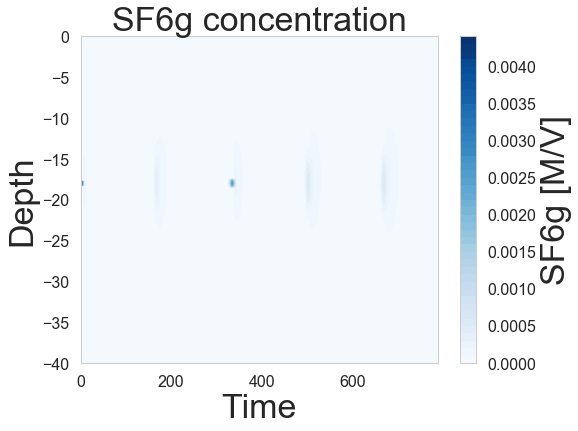

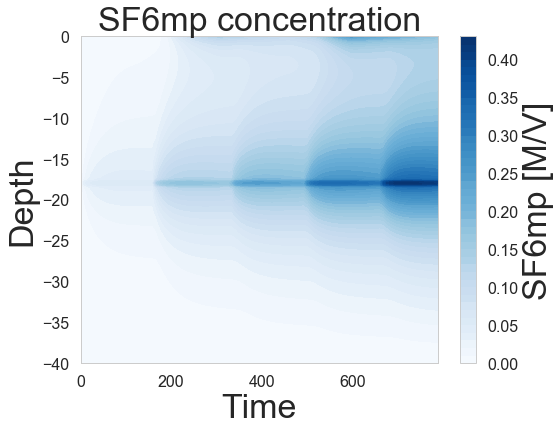

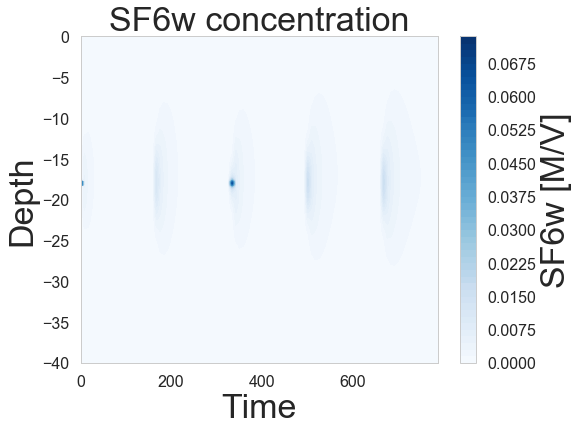

In [15]:
ftc1.plot_contourplots()

In [16]:
Tm.size

46

In [17]:
Tm

array([  2,   4,  20,  22,  45,  47,  93,  95, 116, 118, 168, 170, 212,
       214, 308, 310, 327, 329, 350, 352, 400, 402, 459, 461, 482, 484,
       505, 507, 553, 555, 598, 600, 622, 624, 644, 646, 690, 692, 798,
       800, 819, 821, 843, 845, 896, 898])

In [18]:
C1D9.size

46

In [19]:
C3D9.size

46

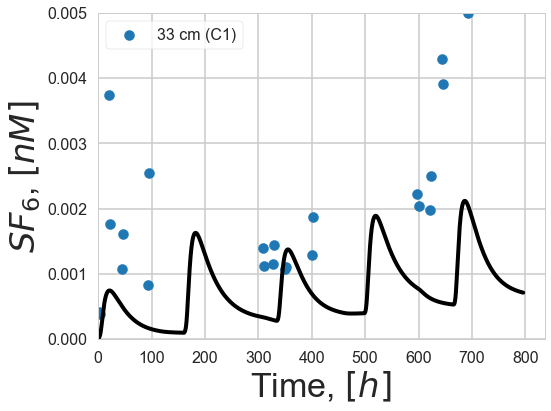

In [31]:
zm = 9
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C2D9+C3D9)/3, label='33 cm (C1)')
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)


(0, 0.059754289379445658)

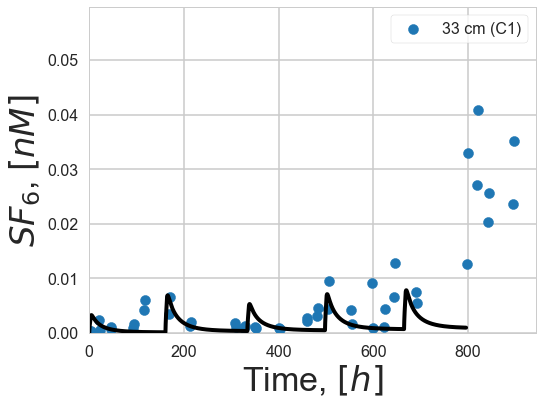

In [30]:
zm = 21
# plt.scatter(Tm, C1D21, label ='21 cm (C1)')
# plt.scatter(Tm, C2D21, label ='21 cm (C2)')
# plt.scatter(Tm, C3D21, label ='21 cm (C3)')
plt.scatter(Tm, (C1D21+C2D21+C3D21)/3, label='33 cm (C1)')
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1)
plt.xlim(0,)
plt.ylim(0,)

(0, 0.001)

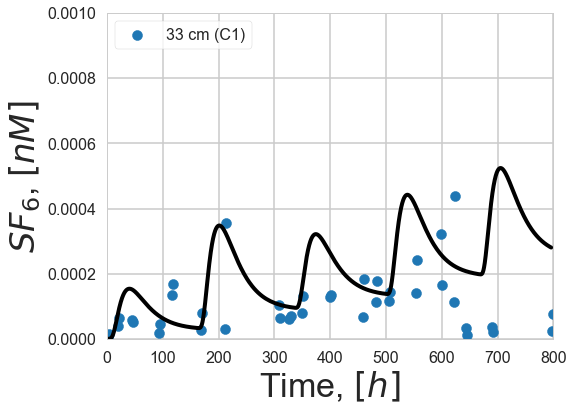

In [29]:
zm = 33
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
# plt.scatter(Tm, C1D33, label='33 cm (C1)')
# plt.scatter(Tm, C2D33, label='33 cm (C2)')
# plt.scatter(Tm, C3D33, label='33 cm (C3)')
plt.scatter(Tm, (C1D33+C2D33+C3D33)/3, label='33 cm (C1)')
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1, loc=2)
plt.xlim(0,800)
plt.ylim(0, 0.001)

(0, 800)

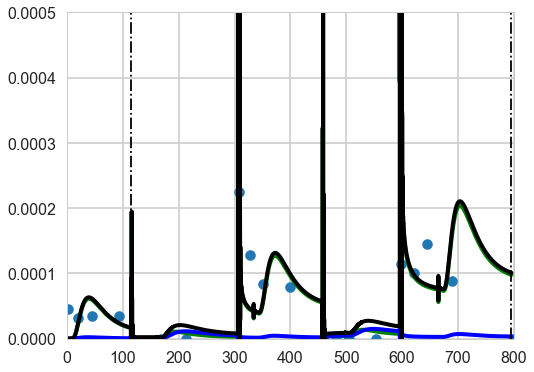

In [23]:
F1 = ftc1.estimate_flux_at_top('SF6g')
F2 = ftc1.estimate_flux_at_top('SF6w')
F3 = ftc1.estimate_flux_at_top('SF6mp')
# # gas flux

plt.plot(ftc1.time, F1, 'g')
plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc1.time, F2+F1+F3, 'k-')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
# dC2h = (C2h[1::2] - C2h[::2])
# dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], dC1h*Vh1/SA/2)
# plt.scatter(Tm, dC2h*Vh2/SA/2)
# plt.scatter(Tm, dC3h*Vh3/SA/2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)


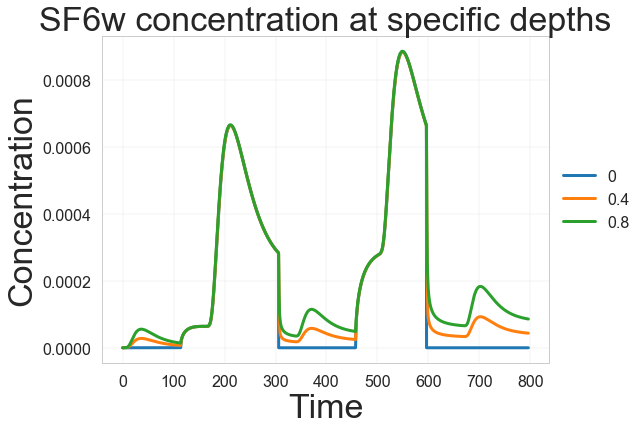

In [24]:
ftc1.plot_depths('SF6w', depths=[0, 0.4, 0.8])

In [25]:
Tm[::2].size

23

In [26]:
dC1h.size

23

In [27]:
C1h[1::2] - dC1h[::2]

ValueError: operands could not be broadcast together with shapes (23,) (12,) 